In [1]:
import sys
sys.path.insert(0, '/home/hwang/libIPS')

In [2]:
from simulate_single_cavity import simulate_single_cavity
from beam import Particle

In [3]:
import numpy as np
from numpy.random import SeedSequence, default_rng
from scipy.optimize import differential_evolution, minimize_scalar, minimize
import pandas as pd
import matplotlib.pyplot as plt
from multiprocessing import Pool
import os
import pickle

In [4]:
import psutil
svmem = psutil.virtual_memory()

def get_mem_usage():
    svmem = psutil.virtual_memory()
    return svmem.used/svmem.available

get_mem_usage()

0.023672295665449147

In [5]:
beam_frequency = 80.5e6
wavelength = 299792458 / beam_frequency
phase_scan = np.arange(256)/256*2*np.pi-np.pi

In [6]:
from info import info
for k,v in info.items():
    print(k)
    for k_,v_ in v.items():
        print(' ',k_+' '*(22-len(k_)),v_)

QWR041
  W_u_range              [400000.0, 3500000.0]
  field_amplitude_range  [0.0, 6.0]
  cav_length             0.24
  qA_range               [0.1, 0.6]
  nLEVEL                 4
QWR085
  W_u_range              [1000000.0, 33000000.0]
  field_amplitude_range  [0.0, 6.0]
  cav_length             0.32
  qA_range               [0.1, 0.6]
  nLEVEL                 4
QWR029
  W_u_range              [12000000.0, 75000000.0]
  field_amplitude_range  [0.0, 8.0]
  cav_length             0.33
  qA_range               [0.2, 0.6]
  nLEVEL                 4
QWR053
  W_u_range              [35000000.0, 320000000.0]
  field_amplitude_range  [0.0, 8.0]
  cav_length             0.49
  qA_range               [0.2, 0.6]
  nLEVEL                 4
MGB
  W_u_range              [10000000.0, 30000000.0]
  field_amplitude_range  [0.0, 8.5]
  cav_length             1.2
  qA_range               [0.2, 0.6]
  nLEVEL                 4


In [7]:
cav_type_name = 'QWR053' 
W_u_range = info[cav_type_name]['W_u_range']
field_amplitude_range = info[cav_type_name]['field_amplitude_range']
qA_range = info[cav_type_name]['qA_range']
cav_length = info[cav_type_name]['cav_length']
nLEVEL = info[cav_type_name]['nLEVEL']

In [8]:
def gamma2beta(gamma):
    return (1.-1./gamma**2)**0.5

def beta2gamma(beta):
    return (1./(1.-beta**2))**0.5

In [9]:
def Wu2beta(w_u):
    gamma = 1.+w_u/931.5e6
    return np.sqrt(1.0 - 1.0 / gamma ** 2)

def beta2Wu(beta):
    gamma = np.sqrt(1./(1.-beta**2))
    return (gamma-1.)*931.5e6

In [10]:
model = simulate_single_cavity(cav_type_name)
cavity = model.cavity
assert cavity.length == cav_length

In [11]:
for key,val in cavity.__dict__.items():
    print(key, ": ",val)

name :  QWR053
zc :  0.0
phase :  0.0
offset :  0.0
beam_beta :  0.0
_model :  Cavity Model from "/home/hwang/libIPS//data//fieldmaps//Ez053.txt" with length = 0.49 m, f = 322.0 MHz
_on :  True
length :  0.49
frequency :  322000000.0
type :  /home/hwang/libIPS//data//fieldmaps//Ez053.txt
scale :  1.0
is_on :  1
is_off :  0
field_amplitude :  0.0
synchronous_phase :  0.0
lo :  0.5
lolo :  0.0
hi :  8.0
hihi :  8.0


In [12]:
def get_input_sample(W_u_range):
    w_u,amplitude = np.random.rand(2)
    w_u = w_u*(W_u_range[1]-W_u_range[0]) + W_u_range[0]
    amplitude *= field_amplitude_range[1] + 0.01
    qA = np.random.rand()*(qA_range[1]-qA_range[0])+qA_range[0]
    return w_u,amplitude,qA

In [13]:
def track(phase,w_u,amplitude,qA,method,phase_offset=0,model=model,test=False):
    A = 100
    Q = qA*A
    if model is None:
        model = simulate_single_cavity(cav_type_name)
    cavity = model.cavity
    cavity.phase = phase
    cavity.offset = phase_offset
    cavity.field_amplitude = amplitude
    particle = Particle(A,Q,w_u)
    particle.z = 0
    particle.tau = 0
    particle.W = w_u*A   
    if test:
        pass
    else:
        model(particle, model.cavity,method=method)
    p = particle
    dWu = p.W/A -w_u
    dTau = p.tau - 2*np.pi*cav_length / (p.beta*wavelength)
    return dTau, dWu

In [14]:
import timeit
import time

def _template_func(setup, func):
    """Create a timer function. Used if the "statement" is a callable."""
    def inner(_it, _timer, _func=func):
        setup()
        _t0 = _timer()
        for _i in _it:
            retval = _func()
        _t1 = _timer()
        return _t1 - _t0, retval
    return inner

timeit._template_func = _template_func

In [15]:
# overhead time cost
def test():
    w_u, amplitude, qA = get_input_sample(W_u_range)
    phase = np.random.rand()*2*np.pi-np.pi
    # for phase in phase_scan:
    _ = track(phase, w_u, amplitude, qA, method='TTF1',model=model,test=True)  
t = timeit.Timer(test)
t_overhead = t.timeit(number=100000)/100000

In [16]:
def test():
    w_u, amplitude, qA = get_input_sample(W_u_range)
    phase = np.random.rand()*2*np.pi-np.pi
    # for phase in phase_scan:
    _ = track(phase, w_u, amplitude, qA, method='TTF1',model=model)  
t = timeit.Timer(test)
tTTF1 = t.timeit(number=100000)/100000 - t_overhead
print('TTF1:',tTTF1*1e6,'micro-sec')

TTF1: 13.572740461677313 micro-sec


In [17]:
def test():
    w_u, amplitude, qA = get_input_sample(W_u_range)
    phase = np.random.rand()*2*np.pi-np.pi
    # for phase in phase_scan:
    _ = track(phase, w_u, amplitude, qA, method='TTF2',model=model)  
t = timeit.Timer(test)
tTTF2 = t.timeit(number=100000)/100000 - t_overhead
print('TTF2:',tTTF2*1e6,'micro-sec')

TTF2: 44.679786004126065 micro-sec


In [18]:
def test():
    w_u, amplitude, qA = get_input_sample(W_u_range)
    phase = np.random.rand()*2*np.pi-np.pi
    # for phase in phase_scan:
    _ = track(phase, w_u, amplitude, qA, method='realistic',model=model)  
t = timeit.Timer(test)
tRealistic = t.timeit(number=10000)/10000 - t_overhead
print('Realistic:',tRealistic*1e3,'msec')

Realistic: 5.258408985864371 msec


In [19]:
def get_single_data(w_u,amplitude,qA,method,phase_scan=phase_scan,model=model):
    dTau = np.zeros(len(phase_scan))
    dW_u = np.zeros(len(phase_scan))
    for i,phase in enumerate(phase_scan):
        dTau[i], dW_u[i] = track(phase,w_u,amplitude,qA,method,0,model=model)
    return dTau, dW_u

In [20]:
class construct_data_generator:
    def __init__(self,W_u_range,phase_scan=phase_scan):
        self.W_u_range = W_u_range
        self.phase_scan = phase_scan
    def __call__(self,n):
        np.random.seed(int.from_bytes(os.urandom(4), byteorder='little'))
        phase_scan = self.phase_scan
        data = {}
        nScan = len(phase_scan)
        for key in ['phase','W/u in','Cav amplitude in','qA','dTau','dW_u']:
            data[key] = np.zeros(n*nScan)
        model = simulate_single_cavity(cav_type_name)
        i = 0
        while(i<n):
            w_u, amplitude, qA = get_input_sample(self.W_u_range)
            i1 = i*nScan
            i2 = (i+1)*nScan
            data['phase'][i1:i2] = phase_scan
            data['W/u in'][i1:i2] = w_u
            data['Cav amplitude in'][i1:i2] = amplitude
            data['qA'][i1:i2] = qA
            data['dTau'][i1:i2], data['dW_u'][i1:i2] = get_single_data(w_u,amplitude,qA,'realistic',phase_scan,
                                                                   model=model)
            i+=1
        return data

# check

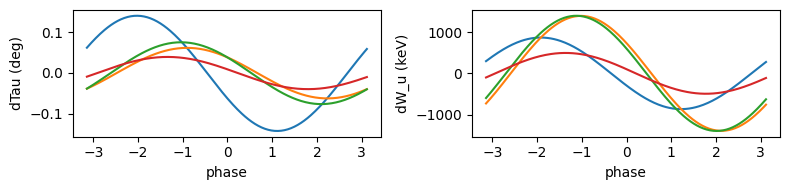

In [21]:
sampler = construct_data_generator(W_u_range)
nScan = len(phase_scan)
data = sampler(4)

fig,ax = plt.subplots(1,2,figsize=(8,2))
for i in range(4):
    i1 = i*nScan
    i2 = (i+1)*nScan
    ax[0].plot(data['phase'][i1:i2],data['dTau'][i1:i2]/np.pi*180)
    ax[1].plot(data['phase'][i1:i2],data['dW_u'][i1:i2]*1e-3)
ax[0].set_xlabel('phase');
ax[1].set_xlabel('phase');
ax[0].set_ylabel('dTau (deg)');
ax[1].set_ylabel('dW_u (keV)');
fig.tight_layout()

# gen_data

In [22]:
def ListData2FlatData(ListData):
    flat_data = {}
    for key in ['phase','W/u in','Cav amplitude in','qA','dTau','dW_u']:
        flat_data[key] = np.concatenate([tmp[key] for tmp in ListData])
    return flat_data

In [ ]:
Np = 16
dW_LEVEL = (W_u_range[1]-W_u_range[0])/nLEVEL

for i in range(nLEVEL):
    W_u_min = W_u_range[0] +i*dW_LEVEL - 0.1*dW_LEVEL
    W_u_max = W_u_range[0] +i*dW_LEVEL + 1.1*dW_LEVEL
    sampler = construct_data_generator([W_u_min,W_u_max])
    ListData = []
    fname = cav_type_name+'_pd'+str(i)+'.pkl'
    for j in range(4):
        with Pool(Np) as p:
            ListData +=  p.map(sampler, [8192]*Np)
        print(i, j, get_mem_usage())
        pickle.dump(ListData2FlatData(ListData),open(fname,'wb'))